# This script test the validity of the code compared to the theoretical displacement due to a double couple (point source dislocation)

## 1) Header

In [34]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src") 

import numpy as np
from axitra import *
import matplotlib.pyplot as pt
#%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2) Theoretical response from Aki & Richards, Formula 4.42 

In [35]:
def GreenTheo(theta, phi, r, alpha, beta, rho, M0, t):
    """
    Compute waveform for a point source shear dislocation
    following Aki&Richards formula 4.42
    
    theta = colatitude (rad)
    phi = azimuth (rad)
    r = radial distance (m)
    alpha = P wave velocity (m/s)
    beta = S wave velocity (m/s)
    rho = volumic mass (kg/m3)
    M0 = seismic moment (SI)
    t = time vector (sec)
    
    return U_r, U_theta, U_phi
    """

    # Near field
    Anf_r = 9.*np.sin(2.*theta)*np.cos(phi)
    Anf_theta = -6.*np.cos(2.*theta)*np.cos(phi)
    Anf_phi = 6.*np.cos(theta)*np.sin(phi)
    # intermediate field
    Aif_P_r = 4.*np.sin(2.*theta)*np.cos(phi)
    Aif_P_theta = -2.*np.cos(2.*theta)*np.cos(phi)
    Aif_P_phi = 2.*np.cos(theta)*np.sin(phi)

    Aif_S_r = -3.*np.sin(2.*theta)*np.cos(phi)
    Aif_S_theta = 3.*np.cos(2.*theta)*np.cos(phi)
    Aif_S_phi = -3.*np.cos(theta)*np.sin(phi)

    # Far-field
    Aff_P_r = np.sin(2.*theta)*np.cos(phi)
    Aff_S_theta = np.cos(2.*theta)*np.cos(phi)
    Aff_S_phi = -np.cos(theta)*np.sin(phi)

    ta = r/alpha  # arrival time P wave
    tb = r/beta  # arraival time S wave
    r2 = r*r
    alpha2 = alpha*alpha
    beta2 = beta*beta
    alpha3 = alpha2*alpha2
    beta3 = beta2*beta
    cof = M0/4./np.pi/rho/r2

    u_r = np.zeros(t.shape)
    u_theta = np.zeros(t.shape)
    u_phi = np.zeros(t.shape)

    
    # for time >r/alpha and time <r/b
    I = np.where((t > ta) & (t <= tb))
    tau = t[I]
    u_r[I] = Anf_r * (tau*tau/2./r2 - 1./2./alpha2)*cof + \
            (Aif_P_r/alpha2 - Aif_S_r/beta2)*cof

    u_theta[I] = Anf_theta * (tau*tau/2./r2 - 1./2./alpha2)*cof + \
                Aif_P_theta/alpha2*cof

    u_phi[I] = Anf_phi * (tau*tau/2./r2 - 1./2./alpha2)*cof + \
                Aif_P_phi/alpha2*cof

    # And the far-field terms
    iP = np.argmin(np.abs(t-ta))
    iS = np.argmin(np.abs(t-tb))
    u_r[iP] += Aff_P_r * cof * r/alpha3
    u_theta[iS] += Aff_S_theta * cof * r/beta3
    u_phi[iS] += -Aff_S_phi * cof * r/beta3

    # for time > r>beta
    u_r[iP+1:] = Anf_r * (1./2./beta2 - 1./2./alpha2)*cof + \
        (Aif_P_r/alpha2 + Aif_S_r/beta2)*cof

    u_theta[iS+1:] = Anf_theta * (1./2./beta2 - 1./2./alpha2)*cof + \
        (Aif_P_theta/alpha2 + Aif_S_theta/beta2)*cof

    u_phi[iS+1:] = Anf_phi * (1./2./beta2 - 1./2./alpha2)*cof + \
        (Aif_P_phi/alpha2 + Aif_S_phi/beta2)*cof

    return u_r, u_theta, u_phi


# 3) Test amplitude and spectra

## Parameters for receiver and source

In [36]:
# ---------------------------------
# 1 source at center and a depth of 5 km
# ---------------------------------
sources=np.array([[1, 0.0, 0.000, 5000.000]])
# We set a strike-slip fault aligned along the source-receiver direction
M0=7.5e20 # Seismic moment
strike = 0.
dip = 90.
rake = 0.
hist = np.array([[1,M0,strike,dip,rake,0.,0.,0.0]])

# ---------------------------------
# 1 receiver at surface along North axis at X km
# ---------------------------------
X = 50000
stations=np.array([[1, X, 0.000, 0.000]])

dist = np.linalg.norm(sources[0,1:4]-stations[0,1:4])
print('radial distance is ',dist, 'meters')

# ---------------------------------
# 1 layer
# ---------------------------------
# thickness (or top), Vp, Vs, rho, Qp, Qs
rho = 2700.  #density
beta = 2886. #Vs
alpha = 5000. #Vp
model = np.array([[00., alpha, beta, rho, 1000., 1000.]])


radial distance is  50249.37810560445 meters


### Low frequency asymptotic level

In [37]:
# ---------------------------------
# We expect the low frequency asymptote to be equal to : M0 /r  / (4*pi*rho*beta^3)
# ---------------------------------
LowFreq_asympt = M0* 1./(4.*np.pi*rho*beta**3) / dist
print('Low frequency asymptote ',LowFreq_asympt)

Low frequency asymptote  18.300711037909867


## Run Green's function calculation

In [38]:
# Fill in the instance of Axitra Class
ap = Axitra(model, stations, sources, fmax=50., duration=100., xl=500000., latlon=False,freesurface=False,axpath='../src')
print('npt',ap.npt)

# Compute green's function
ap = moment.green(ap)

npt 16384
  with            1 source(s) and            1 receiver(s) and            1 layer(s)
 ................. with no free surface
 distance unit is detected as meter
freq  1059/ 5000 iter=     1836

 running axitra Moment Version 20212403.1
 running openMp on           10  threads


freq  4999/ 5000 iter=     8644 Doner=     6428
../src/axitra ran sucessfully


## Compute convolution for different source time function

In [39]:
# ---------------------------------
# 0: dirac source and output is an integration of displacement
# 2: smooth acausal step
# 4: step as an integral of a triangle
# 5: step with a linear ramp 
# 7: Heaviside
# 8: step as an integral of a trapezoid
# ---------------------------------
t, sx_0, sy_0, sz_0 = moment.conv(ap,hist,source_type=0,t0=0.05,unit=0)
t, sx_2, sy_2, sz_2 = moment.conv(ap,hist,source_type=2,t0=0.05,unit=1)
t, sx_4, sy_4, sz_4 = moment.conv(ap,hist,source_type=4,t0=0.05,unit=1)
t, sx_5, sy_5, sz_5 = moment.conv(ap,hist,source_type=5,t0=0.05,unit=1)
t, sx_7, sy_7, sz_7 = moment.conv(ap,hist,source_type=7,t0=0.05,unit=1)
t, sx_8, sy_8, sz_8 = moment.conv(ap,hist,source_type=8,t0=0.05,t1=0.1,unit=1)

 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027
 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027
 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027
 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027
 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027
 Moment (Nm):   7.5000000000000000E+020
 Moment (Dyne.cm):   7.5000000000000002E+027


 running openMp on           10  threads
 running openMp on           10  threads
 running openMp on           10  threads
 running openMp on           10  threads
 running openMp on           10  threads
 running openMp on           10  threads


## Compute theoretical result

In [40]:
phi = 0
theta = np.pi/2. - np.arcsin(0.1) # 5km/50km
# warning reverse convention on rake direction
u_r, u_theta, u_phi = GreenTheo(theta, phi, dist, alpha, beta, rho, -M0, t)

## Plot results

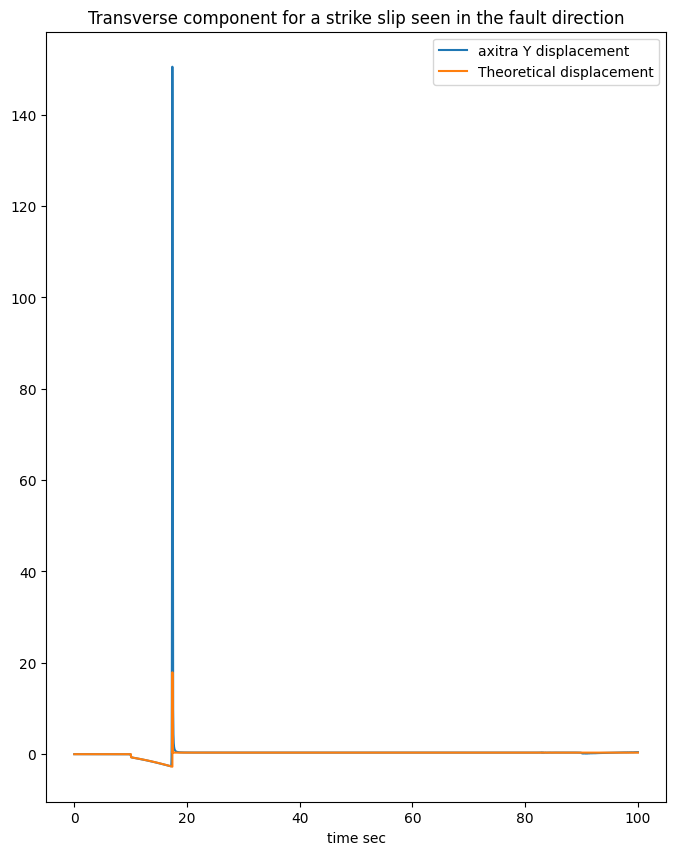

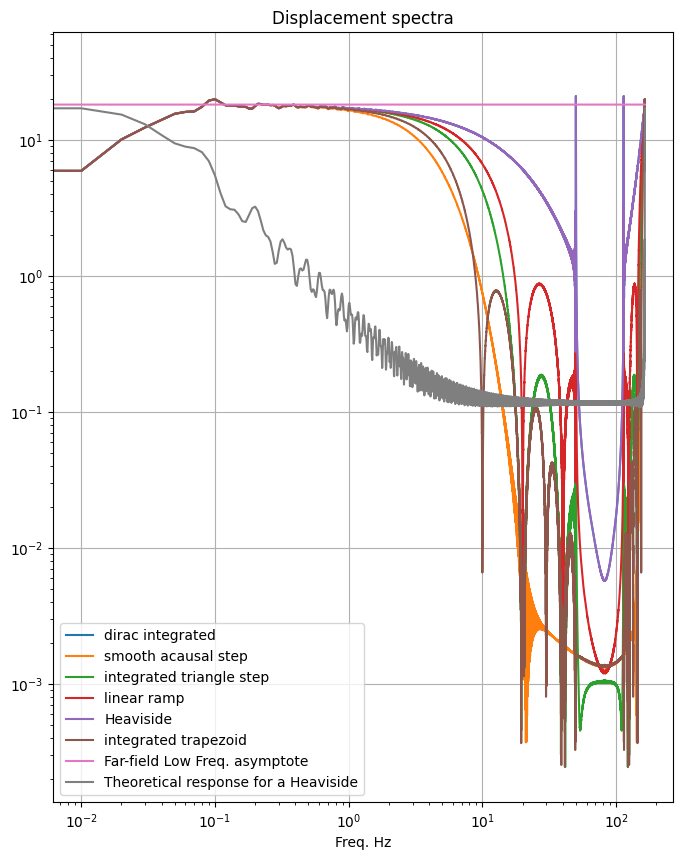

In [41]:
pt.figure(figsize=(8, 10))
#pt.subplot(2,1,1)
ier = pt.plot(t,sy_2[0,:])
pt.xlabel('time sec')
pt.title('Transverse component for a strike slip seen in the fault direction')
pt.plot(t,u_theta)
pt.legend(['axitra Y displacement','Theoretical displacement']);

pt.show()

pt.figure(figsize=(8, 10))
#pt.subplot(2,1,2)
pt.xlabel('Freq. Hz')
pt.title('Displacement spectra')
pt.grid()
nfreq = t.size
df=1./t[-1]
dt=t[1]-t[0]
f = np.arange(0,nfreq)*df
pt.loglog(f, np.abs(np.fft.fft(sy_0[0,:]))*dt, f, np.abs(np.fft.fft(sy_2[0,:]))*dt, f, np.abs(np.fft.fft(sy_4[0,:]))*dt,
          f, np.abs(np.fft.fft(sy_5[0,:]))*dt,f, np.abs(np.fft.fft(sy_7[0,:]))*dt, f, np.abs(np.fft.fft(sy_8[0,:]))*dt,
          f, f*0.+LowFreq_asympt, f, np.abs(np.fft.fft(u_theta))*dt)

pt.legend(['dirac integrated','smooth acausal step','integrated triangle step',
           'linear ramp','Heaviside','integrated trapezoid','Far-field Low Freq. asymptote',
           'Theoretical response for a Heaviside'])